In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Add, Concatenate, MaxPooling2D, AveragePooling2D, concatenate, Flatten, Dense, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
import pandas as pd


2024-03-17 10:19:26.217563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 10:19:27.591548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [7]:
BATCH_SIZE = 16
seeds = 41
im_shape = (250,250)

<span style=" font-family: Times New Roman ; font-size: 35px">
    Resize image </span>

In [56]:
import glob
import cv2

def resize_images(input_folder, output_folder, new_size):
 
    class_folders = glob.glob(os.path.join(input_folder, '*'))

    for class_folder in class_folders:
  
        image_files = glob.glob(os.path.join(class_folder, '*.*'))


        output_class_folder = os.path.join(output_folder, os.path.basename(class_folder))
        os.makedirs(output_class_folder, exist_ok=True)

  
        for img_path in image_files:
            try:
          
                image = cv2.imread(img_path)

        
                resized_image = cv2.resize(image, new_size)

    
                output_path = os.path.join(output_class_folder, os.path.basename(img_path))

   
                cv2.imwrite(output_path, resized_image)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")

TRAIN_DIR  = "data/RiceLeafsDisease/training_1/"
TEST_DIR = "data/RiceLeafsDisease/evaluation_1/"
new_size = (250, 250)

resize_images(TRAIN_DIR, TEST_DIR, new_size)
resize_images(TEST_DIR, TEST_DIR, new_size)

In [8]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,validation_split=0.15)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,validation_split=0.15)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1788 images belonging to 6 classes.
Found 312 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


In [9]:
def plotImages(image_arr):
    fig,axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

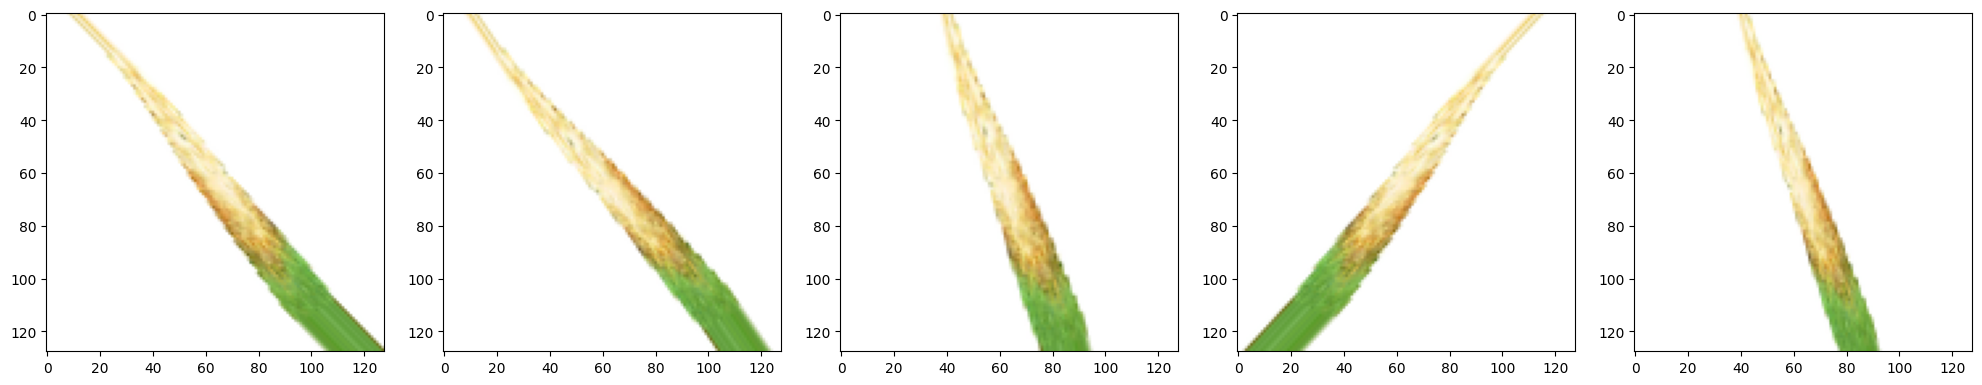

In [10]:
# Plot a few training images
img_array = [train_generator[0][0][0] for i in range(5)]
plotImages(img_array)

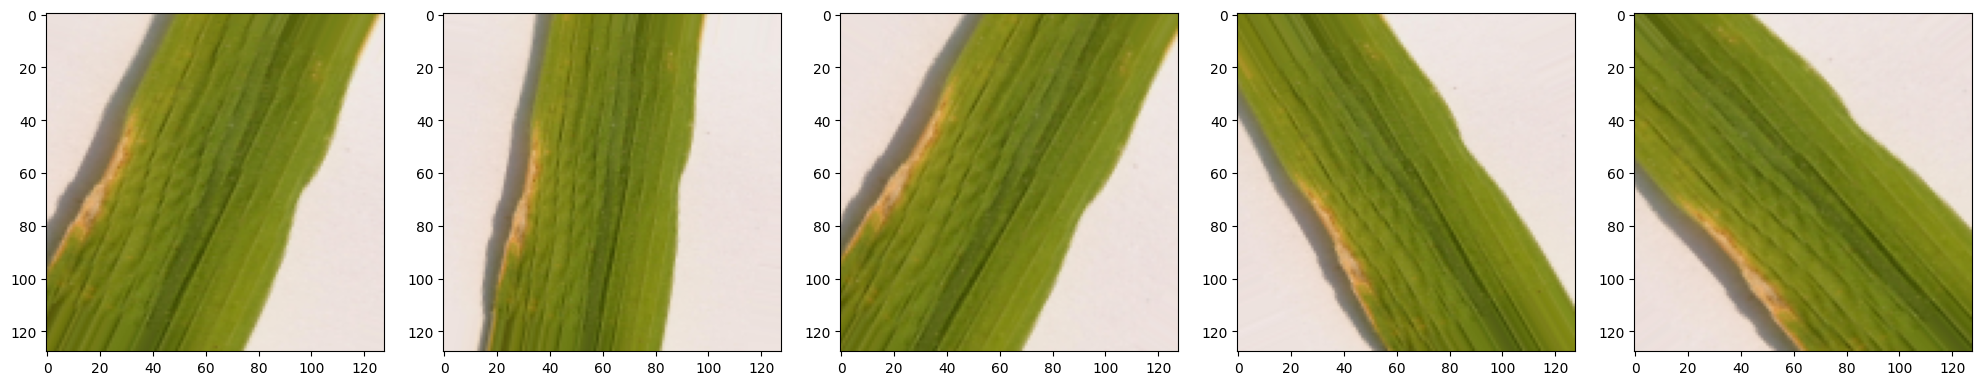

In [12]:
# plot a few val images
img_array  = [validation_generator[0][0][0] for i in range(5)]
plotImages(img_array)

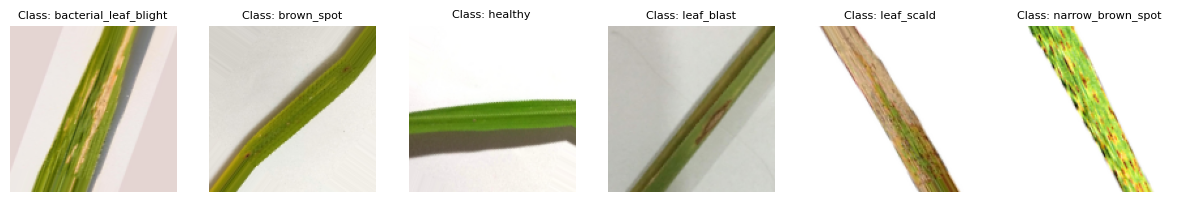

In [8]:
# obtain image and label list from train_generator
# Get category index
class_indices = train_generator.class_indices

# Initializes a dictionary to store the first graph for each category
first_images = {}

# Extract the first graph for each category
for class_name, class_index in class_indices.items():
    # Find the image index for this category
    train_generator.reset()  # Reset the generator to ensure you start from scratch
    found = False
    while not found:
        batch = next(train_generator)
        for index, label in enumerate(batch[1]):
            if label[class_index] == 1:
                first_images[class_name] = batch[0][index]
                found = True
                break


# Displays the first image for each category in a single row
fig, axes = plt.subplots(1, len(first_images), figsize=(15, 3))  # Adjust figsize as needed

for i, (class_name, image) in enumerate(first_images.items()):
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}', fontsize=8)
    axes[i].axis('off')

plt.show()

In [34]:
import os
import numpy as np
from keras.preprocessing import image

def load_images_from_folder(folder_path, target_size=(250, 250)):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder_path))  # 获取文件夹中的类别名称并排序

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array /= 255.0  # 归一化像素值
            images.append(img_array)
            labels.append(i)  # 根据类别名称的索引作为标签

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, class_names

# 使用示例
folder_path = "data/RiceLeafsDisease/train/"
images, labels, class_names = load_images_from_folder(folder_path)
print("Loaded images shape:", images.shape)
print("Loaded labels shape:", labels.shape)
print("Class names:", class_names)

Loaded images shape: (2100, 250, 250, 3)
Loaded labels shape: (2100,)
Class names: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


#### **Fetching images path for 4 classes for mendley rice dataset**

In [37]:
# startified vis func
def distribution_vis_check(train, valid):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index]
  ydf = [train.values, valid.values]
  label = ['Train Distribution', 'Validation Distribution']
  fig = plt.figure(figsize=(20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)

In [39]:
images, labels = validation_generator.next()

# images 是一个形状为 (batch_size, image_height, image_width, num_channels) 的张量
# labels 是一个形状为 (batch_size,) 的张量，其中包含每个图像的类别标签

# 示例输出图像和标签的形状
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (16, 250, 250, 3)
Labels shape: (16, 6)


/tmp/ipykernel_20538/3986727453.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=sns.color_palette('hls',6))


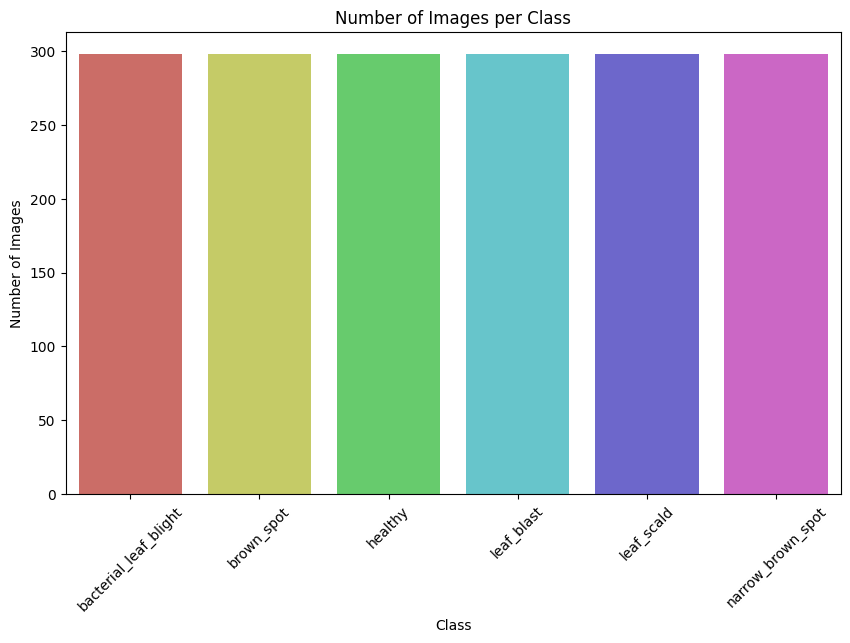

In [54]:
import seaborn as sns

# 获取一个批量的标签
labels = train_generator.classes

# 获取类别名称
class_names = list(validation_generator.class_indices.keys())

# 计算每个类别的图像数量
class_counts = {class_name: np.sum(labels == i) for i, class_name in enumerate(class_names)}

# 创建深色调色板

# 创建柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=sns.color_palette('hls',6))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)  # 旋转 x 轴标签，以避免重叠
# 在每个柱子的顶部添加数字标签
plt.show()

# Inception model 

In [9]:
from keras.layers import Input, Conv2D, DepthwiseConv2D, Concatenate, Add, AveragePooling2D, Flatten, Dense

def inception_module(x, filters):
    # Branch 1:1 x1 convolution
    branch_1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)

    # Branch 2: depth-separable convolution (3x3)
    branch_3x3 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters=filters[1], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_3x3)

    # Branch 3: Depth-separable Convolution (5x5)
    branch_5x5 = DepthwiseConv2D(kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_5x5)

    # The branch 4:3x3 is maximized and then convolved with 1x1
    branch_pool = AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    branch_pool = Conv2D(filters=filters[3], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return output

def residual_block(x, filters):
    # Save the input for subsequent residual connections
    shortcut = x

    # The first Inception module
    x = inception_module(x, filters)

    # The Second Inception module
    x = inception_module(x, filters)

    # If the input and output dimensions do not match, the dimensions are adjusted using 1x1 convolution
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv2D(filters=x.shape[-1], kernel_size=(1, 1), strides=1, padding='same')(shortcut)

    # Residual connection
    x = Add()([shortcut, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(250, 250, 3))

# Convolution layer
conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(input_layer)

# Residual block
res_block1 = residual_block(conv1, [32, 64, 128, 32])
res_block2 = residual_block(res_block1, [64, 64, 128, 32])

# Average pooling layer
pool2 = AveragePooling2D(pool_size=(4, 4))(res_block2)

# Fully connected layer
flatten = Flatten()(pool2)
output_layer = Dense(6, activation='softmax')(flatten)

model = Model(inputs=input_layer, outputs=output_layer)

2024-03-17 10:21:02.363944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 10:21:02.502593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 10:21:02.503096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 125, 125, 64)         4864      ['input_1[0][0]']             
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 125, 125, 64)         640       ['conv2d[0][0]']              
 eConv2D)                                                                                         
                                                                                                  
 depthwise_conv2d_1 (Depthw  (None, 125, 125, 64)         1664      ['conv2d[0][0]']          

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
import time
# Record the start time of training
start_time = time.time()

In [13]:
# Train the model
epochs = 40

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='Depth_Incep_Res_model.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history_1 = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/40


2024-03-17 10:21:38.332436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-17 10:21:44.105531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-17 10:21:44.303862: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe654130280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-17 10:21:44.303903: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-17 10:21:44.467590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-17 10:21:45.237720: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

111/111 [==============================] - ETA: 0s - loss: 1.6538 - accuracy: 0.3736
Epoch 1: val_loss improved from inf to 1.20255, saving model to Depth_Incep_Res_model.h5
111/111 [==============================] - 68s 411ms/step - loss: 1.6538 - accuracy: 0.3736 - val_loss: 1.2026 - val_accuracy: 0.6118
Epoch 2/40


/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.6123
Epoch 2: val_loss improved from 1.20255 to 1.05146, saving model to Depth_Incep_Res_model.h5
111/111 [==============================] - 44s 392ms/step - loss: 1.0395 - accuracy: 0.6123 - val_loss: 1.0515 - val_accuracy: 0.6151
Epoch 3/40
111/111 [==============================] - ETA: 0s - loss: 0.8982 - accuracy: 0.6659
Epoch 3: val_loss did not improve from 1.05146
111/111 [==============================] - 45s 403ms/step - loss: 0.8982 - accuracy: 0.6659 - val_loss: 1.0937 - val_accuracy: 0.6283
Epoch 4/40
111/111 [==============================] - ETA: 0s - loss: 0.8531 - accuracy: 0.6806
Epoch 4: val_loss improved from 1.05146 to 0.93378, saving model to Depth_Incep_Res_model.h5
111/111 [==============================] - 42s 379ms/step - loss: 0.8531 - accuracy: 0.6806 - val_loss: 0.9338 - val_accuracy: 0.6184
Epoch 5/40
111/111 [==============================] - ETA: 0s - loss: 0.7766 - accuracy:

In [14]:
# Record the training end time
end_time = time.time()

In [15]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 2118.5413682460785 seconds


In [16]:
pd.DataFrame(history_1.history)

,loss,accuracy,val_loss,val_accuracy
0,1.653759,0.373589,1.202555,0.611842
1,1.039499,0.612302,1.051463,0.615132
2,0.898217,0.665914,1.093688,0.628289
3,0.853089,0.680587,0.933777,0.618421
4,0.776606,0.713318,0.947147,0.684211
5,0.648074,0.752822,0.828994,0.680921
6,0.717011,0.751693,0.898609,0.680921
7,0.657162,0.753386,0.807280,0.684211
8,0.628444,0.780474,0.648983,0.766447
9,0.520420,0.820542,0.567946,0.789474


In [17]:
import joblib

joblib.dump(history_1.history,'history_CNN1.pkl')
history_CNN1 = joblib.load('history_CNN1.pkl')

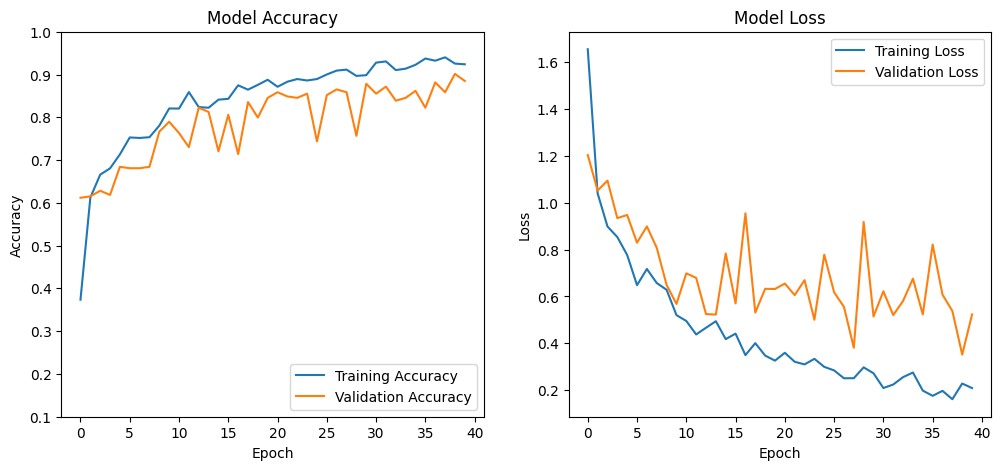

In [18]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN1['accuracy'])
plt.plot(history_CNN1['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN1['loss'])
plt.plot(history_CNN1['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [19]:
# Load the best saved model
from keras.models import load_model

model = load_model('Depth_Incep_Res_model.h5')
score = model.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

20/20 [==============================] - 7s 309ms/step - loss: 0.4448 - accuracy: 0.8974

Val loss: 0.4447510540485382
Val accuracy: 0.8974359035491943
33/33 [==============================] - 11s 334ms/step - loss: 0.2702 - accuracy: 0.9110

Test loss: 0.2701547145843506
Test accuracy: 0.9109848737716675


In [20]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

33/33 [==============================] - 11s 322ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.98      0.99        88
           brown_spot       0.84      0.92      0.88        88
              healthy       0.94      0.86      0.90        88
           leaf_blast       0.80      0.75      0.77        88
           leaf_scald       0.99      1.00      0.99        88
    narrow_brown_spot       0.93      0.98      0.96        88

             accuracy                           0.91       528
            macro avg       0.92      0.91      0.91       528
         weighted avg       0.92      0.91      0.91       528



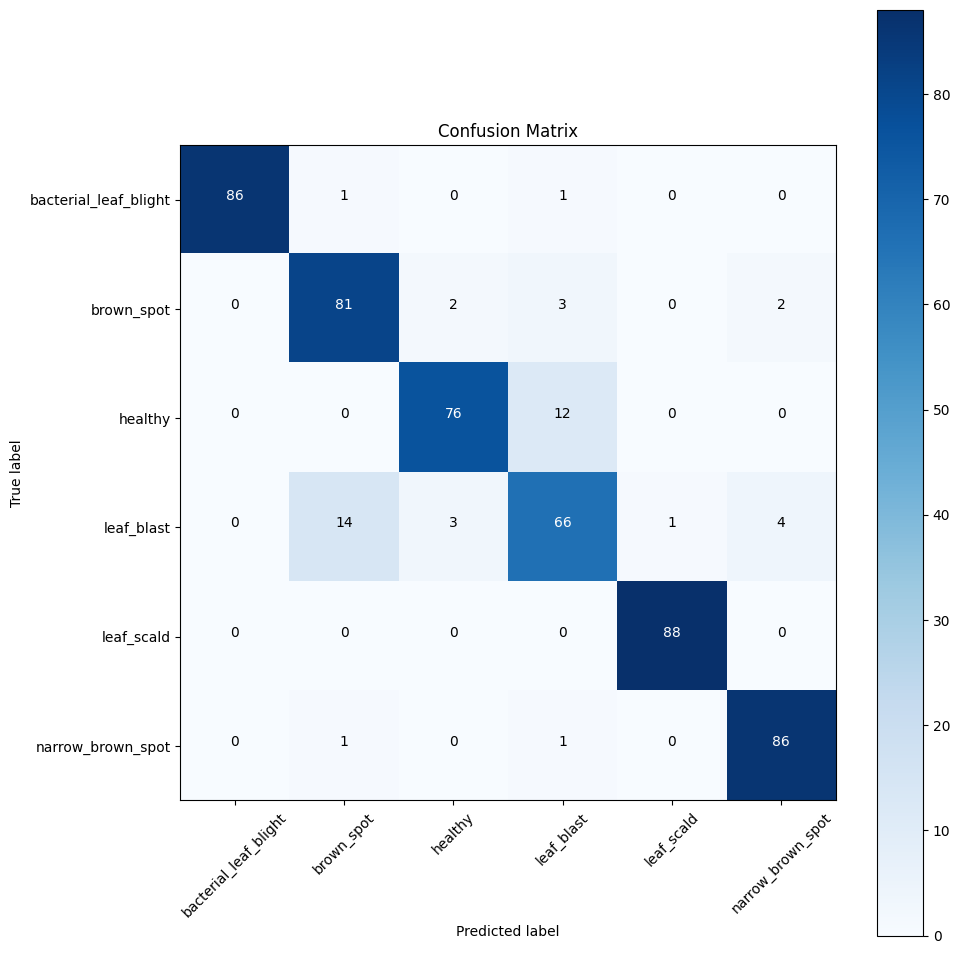

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

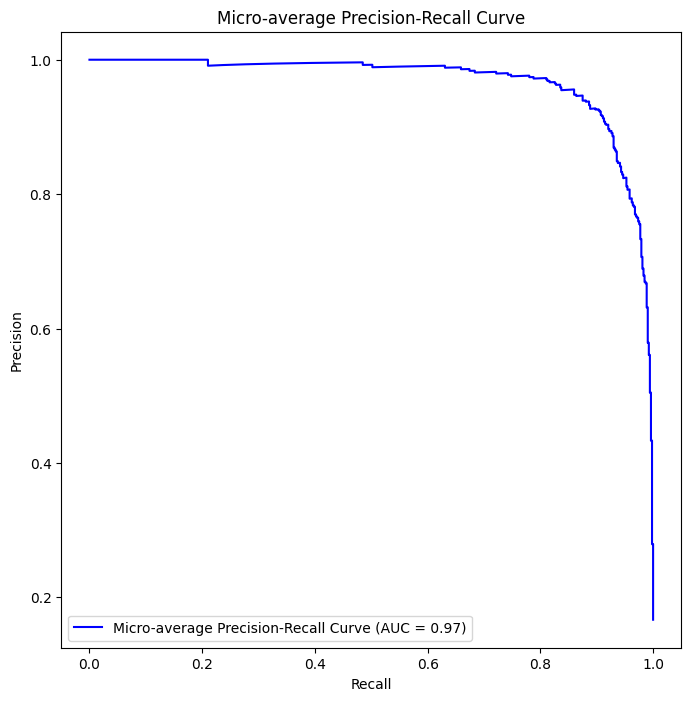

In [22]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Precision-Recall Curve for each class
n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), Y_pred.ravel())
auc_score["micro"] = auc(recall["micro"], precision["micro"])

# Plot micro-average Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall["micro"], precision["micro"], label=f'Micro-average Precision-Recall Curve (AUC = {auc_score["micro"]:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve')
plt.legend()
plt.show()

In [23]:
#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

33/33 [==============================] - 10s 309ms/step


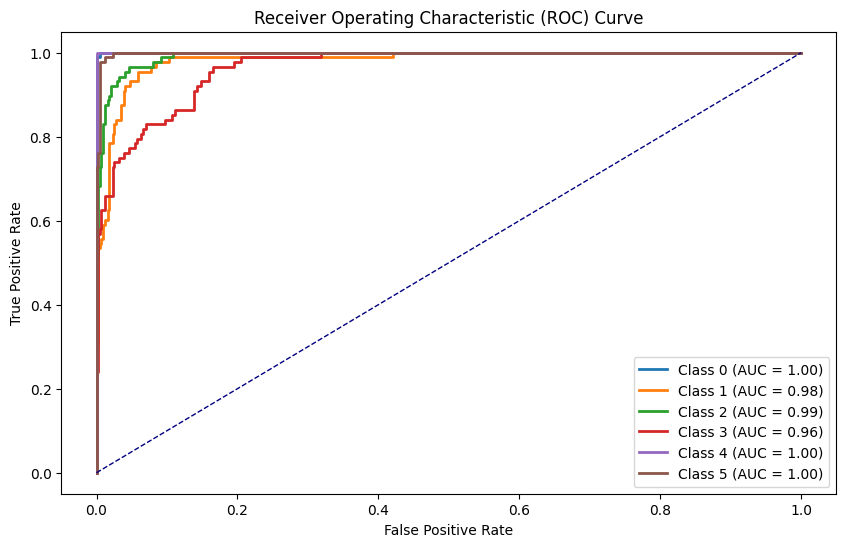

In [24]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc


#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

Class 0 - Sensitivity: 0.9772727272716167, Specificity: 0.9999999999997727
Class 1 - Sensitivity: 0.9204545454534995, Specificity: 0.9636363636361447
Class 2 - Sensitivity: 0.8636363636353822, Specificity: 0.9886363636361389
Class 3 - Sensitivity: 0.7499999999991477, Specificity: 0.9613636363634179
Class 4 - Sensitivity: 0.9999999999988636, Specificity: 0.997727272727046
Class 5 - Sensitivity: 0.9772727272716167, Specificity: 0.9863636363634122


In [26]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

33/33 [==============================] - 11s 327ms/step - loss: 0.2767 - accuracy: 0.9110
Accuracy Test : 0.9109848737716675


1/1 [==============================] - 0s 20ms/step


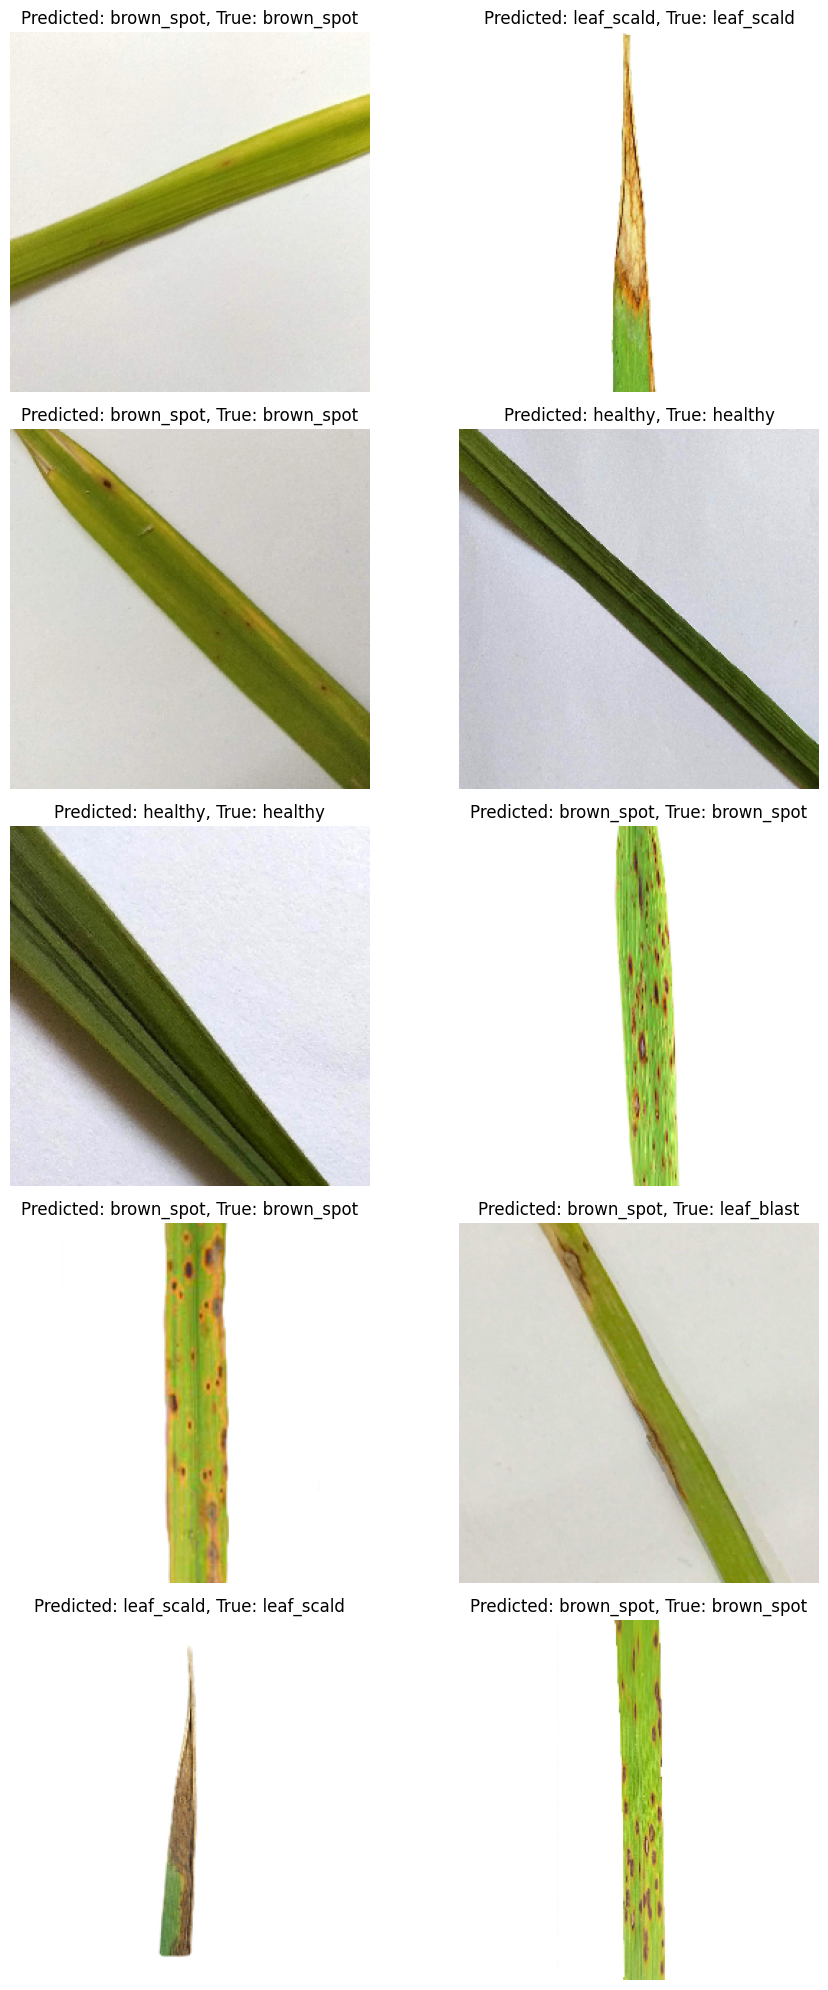

In [27]:
from keras.preprocessing import image as keras_image
# 10 images are randomly selected
random_indices = np.random.choice(len(test_generator.filenames), size=10, replace=False)

# Create a subplot with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for idx, ax in zip(random_indices, axes.flat):
    img_path = test_generator.filepaths[idx]

    # Load and preprocess images
    img = keras_image.load_img(img_path, target_size=(250, 250))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make model prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Get real tags
    true_label = test_generator.classes[idx]

    # Visualizations and results
    class_names = list(test_generator.class_indices.keys())

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted: {class_names[predicted_class]}, True: {class_names[true_label]}")

plt.tight_layout()
plt.show()

In [30]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [31]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()